# Goals

We are going to build a simple CB-IAM, based on the SC-IAM we built in Lab 3.

To do that, we need:
 - A model of emissions
 - Estimates of mitigation costs
 - An optimization step

# Get a new dataset

The dataset comes from the ENGAGE project, an intermodel comparison of DP-IAMs:
https://data.ene.iiasa.ac.at/engage/#/downloads

The full dataset is 95 MB and includes 9 PB-IAMs and 182 scenarios:
https://www.dropbox.com/s/u3drzbpl91r331z/ENGAGE_scenario_data_world_r2.0.csv?dl=0

We are just going to use the data from one DP-IAM called AIM/CGE which includes a computational general equilibrium model and a sophisticated energy system. And we are only going to use the "no policy" scenario.

Download the file from
https://www.dropbox.com/s/dqh0lj3h2xgxbxm/aimcge-np.csv?dl=0

In [1]:
input = read.csv("~/Open Modeling Group Dropbox/Climate Change Economics/labs/lab5/aimcge-np.csv")

In [3]:
head(input)

,Model,Scenario,Region,Variable,Unit,X2000,X2001,X2002,X2003,X2004,⋯,X2091,X2092,X2093,X2094,X2095,X2096,X2097,X2098,X2099,X2100
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AIM/CGE V2.2,EN_NPi2100,World,Agricultural Demand,million t DM/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,5840.6529,NA,NA,NA,NA,5908.8598
2,AIM/CGE V2.2,EN_NPi2100,World,Agricultural Production|Energy|Crops,million t DM/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,714.2877,NA,NA,NA,NA,764.4235
3,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Biomass,GW/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,11.2781,NA,NA,NA,NA,12.1047
4,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Coal,GW/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,300.2123,NA,NA,NA,NA,360.5276
5,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Gas,GW/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,102.8130,NA,NA,NA,NA,131.9642
6,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Geothermal,GW/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,3.4287,NA,NA,NA,NA,3.6637


In [4]:
tail(input)

,Model,Scenario,Region,Variable,Unit,X2000,X2001,X2002,X2003,X2004,⋯,X2091,X2092,X2093,X2094,X2095,X2096,X2097,X2098,X2099,X2100
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
246,AIM/CGE V2.2,EN_NPi2100,World,Secondary Energy|Heat,EJ/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,35.2617,NA,NA,NA,NA,36.5654
247,AIM/CGE V2.2,EN_NPi2100,World,Secondary Energy|Liquids,EJ/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,264.6853,NA,NA,NA,NA,259.6546
248,AIM/CGE V2.2,EN_NPi2100,World,Secondary Energy|Solids,EJ/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,26.2072,NA,NA,NA,NA,25.2351
249,AIM/CGE V2.2,EN_NPi2100,World,Water Consumption|Irrigation,km3/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,3785.7635,NA,NA,NA,NA,3895.4368
250,AIM/CGE V2.2,EN_NPi2100,World,Water Withdrawal|Irrigation,million m3/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,5699.5827,NA,NA,NA,NA,5761.8854
251,AIM/CGE V2.2,EN_NPi2100,World,Yield|Cereal,t DM/ha/yr,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,4.5778,NA,NA,NA,NA,4.6017


In [5]:
unique(input$Variable)

[1] "Agricultural Demand"                                                               
  [2] "Agricultural Production|Energy|Crops"                                              
  [3] "Capacity Additions|Electricity|Biomass"                                            
  [4] "Capacity Additions|Electricity|Coal"                                               
  [5] "Capacity Additions|Electricity|Gas"                                                
  [6] "Capacity Additions|Electricity|Geothermal"                                         
  [7] "Capacity Additions|Electricity|Hydro"                                              
  [8] "Capacity Additions|Electricity|Nuclear"                                            
  [9] "Capacity Additions|Electricity|Oil"                                                
 [10] "Capacity Additions|Electricity|Solar"                                              
 [11] "Capacity Additions|Electricity|Solar|PV"                                           
 [12] "Capacity Additions|Electricity|Wind"                                               
 [13] "Capacity|Electricity"                                                              
 [14] "Capacity|Electricity|Biomass"                                                      
 [15] "Capacity|Electricity|Biomass|w/o CCS"                                              
 [16] "Capacity|Electricity|Coal"                                                         
 [17] "Capacity|Electricity|Coal|w/o CCS"                                                 
 [18] "Capacity|Electricity|Gas"                                                          
 [19] "Capacity|Electricity|Gas|w/o CCS"                                                  
 [20] "Capacity|Electricity|Geothermal"                                                   
 [21] "Capacity|Electricity|Hydro"                                                        
 [22] "Capacity|Electricity|Nuclear"                                                      
 [23] "Capacity|Electricity|Oil"                                                          
 [24] "Capacity|Electricity|Oil|w/o CCS"                                                  
 [25] "Capacity|Electricity|Other"                                                        
 [26] "Capacity|Electricity|Solar"                                                        
 [27] "Capacity|Electricity|Solar|PV"                                                     
 [28] "Capacity|Electricity|Wind"                                                         
 [29] "Capacity|Electricity|Wind|Onshore"                                                 
 [30] "Capital Cost|Electricity|Biomass|w/o CCS"                                          
 [31] "Capital Cost|Electricity|Coal|w/o CCS"                                             
 [32] "Capital Cost|Electricity|Gas|w/o CCS"                                              
 [33] "Capital Cost|Electricity|Geothermal"                                               
 [34] "Capital Cost|Electricity|Hydro"                                                    
 [35] "Capital Cost|Electricity|Nuclear"                                                  
 [36] "Capital Cost|Electricity|Solar|PV"                                                 
 [37] "Capital Cost|Electricity|Wind|Onshore"                                             
 [38] "Capital Cost|Liquids|Biomass|w/o CCS"                                              
 [39] "Capital Cost|Liquids|Oil"                                                          
 [40] "Carbon Sequestration|Land Use|Afforestation"                                       
 [41] "Consumption"                                                                       
 [42] "Diagnostics|MAGICC6|Carbon Flow|Fossil"                                            
 [43] "Diagnostics|MAGICC6|Carbon Flow|Land Use"                                          
 [44] "Diagnostics|MAGICC6|Carbon Flow|Perma Frost"                                      

* What does the data look like?
* What variables are in the data?

In [9]:
install.packages("reshape2")

Installing package into ‘/Users/admin/Library/R/x86_64/4.1/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/rl/p7xkj5n56gb2hxfnwbc696x80000gn/T//Rtmp4WYAir/downloaded_packages


In [6]:
library(reshape2)

In [11]:
input2 = melt(input, c('Model', 'Scenario', 'Region', 'Variable', 'Unit'))

In [12]:
head(input2)

,Model,Scenario,Region,Variable,Unit,variable,value
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,AIM/CGE V2.2,EN_NPi2100,World,Agricultural Demand,million t DM/yr,X2000,NA
2,AIM/CGE V2.2,EN_NPi2100,World,Agricultural Production|Energy|Crops,million t DM/yr,X2000,NA
3,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Biomass,GW/yr,X2000,NA
4,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Coal,GW/yr,X2000,NA
5,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Gas,GW/yr,X2000,NA
6,AIM/CGE V2.2,EN_NPi2100,World,Capacity Additions|Electricity|Geothermal,GW/yr,X2000,NA


In [13]:
input2 = subset(input2, !is.na(value))

In [14]:
input2$year = as.numeric(substring(input2$variable, 2, 5))

In [15]:
head(input2)

,Model,Scenario,Region,Variable,Unit,variable,value,year
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1297,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Carbon Flow|Fossil,GtC/yr,X2005,7.97100e+00,2005
1298,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Carbon Flow|Land Use,GtC/yr,X2005,1.19550e+00,2005
1299,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Carbon Flow|Perma Frost,GtC/yr,X2005,1.70646e-02,2005
1300,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CH4,ppb,X2005,1.75316e+03,2005
1301,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2005,3.79850e+02,2005
1302,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|N2O,ppb,X2005,3.19855e+02,2005


In [16]:
temp = subset(input2, Variable == 'Diagnostics|MAGICC6|Temperature|Global Mean')

In [17]:
head(temp)

,Model,Scenario,Region,Variable,Unit,variable,value,year
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1343,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2005,0.9131088,2005
1594,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2006,0.9342040,2006
1845,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2007,0.9125382,2007
2096,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2008,0.9232636,2008
2347,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2009,0.9531263,2009
2598,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Temperature|Global Mean,√Ç¬∞C,X2010,0.9883230,2010


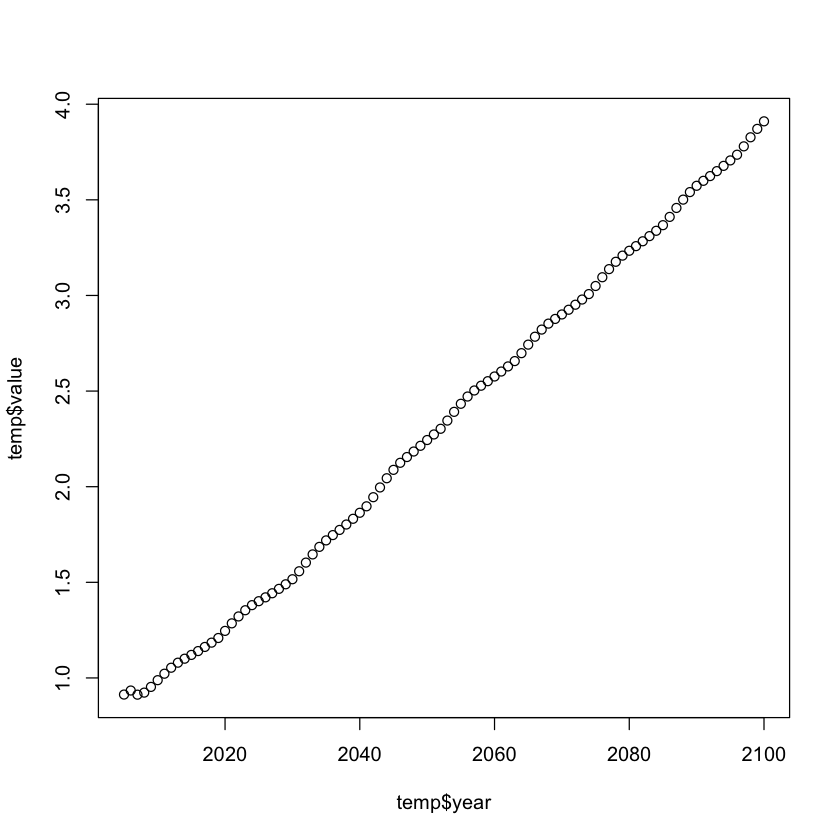

In [18]:
plot(temp$year, temp$value)

* How can we plot these data?

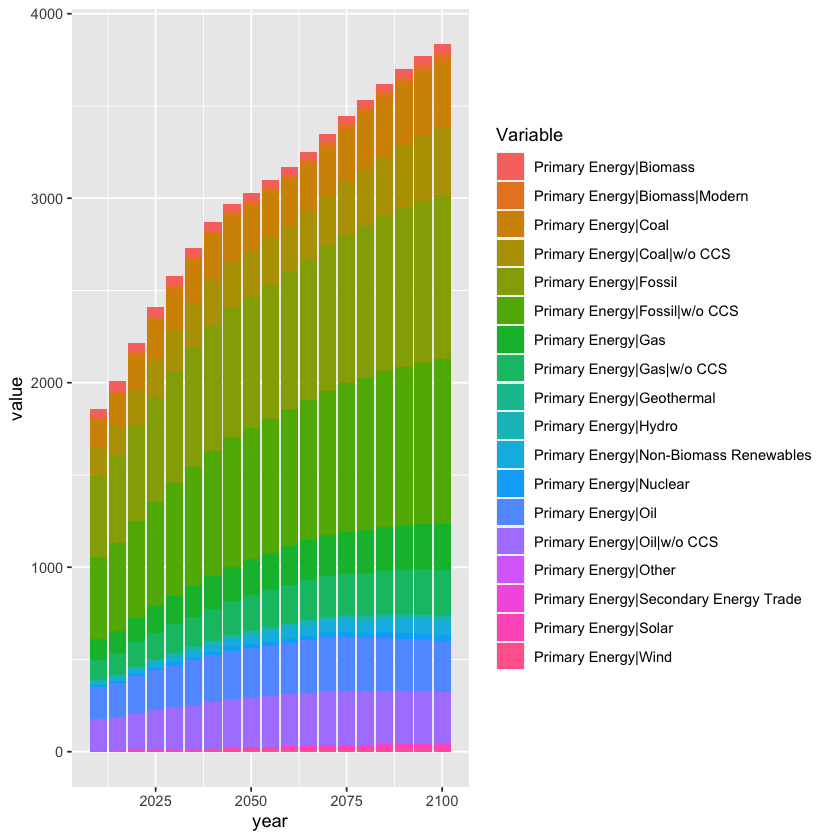

In [19]:
library(ggplot2)
ggplot(input2[grep("Primary Energy\\|", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

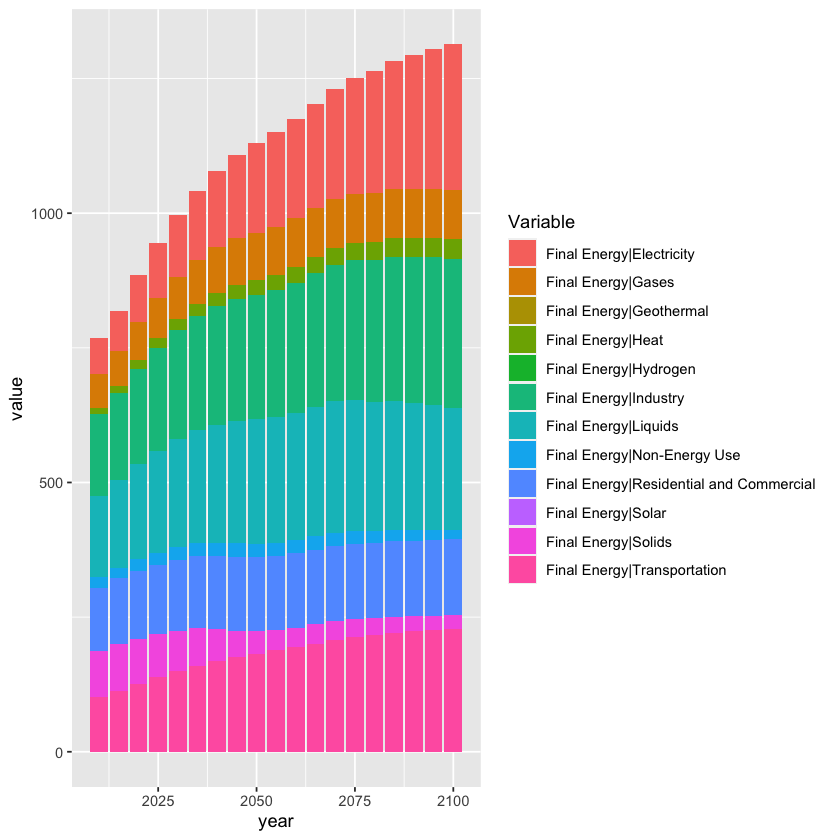

In [20]:
ggplot(input2[grep("Final Energy\\|[^|]+$", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

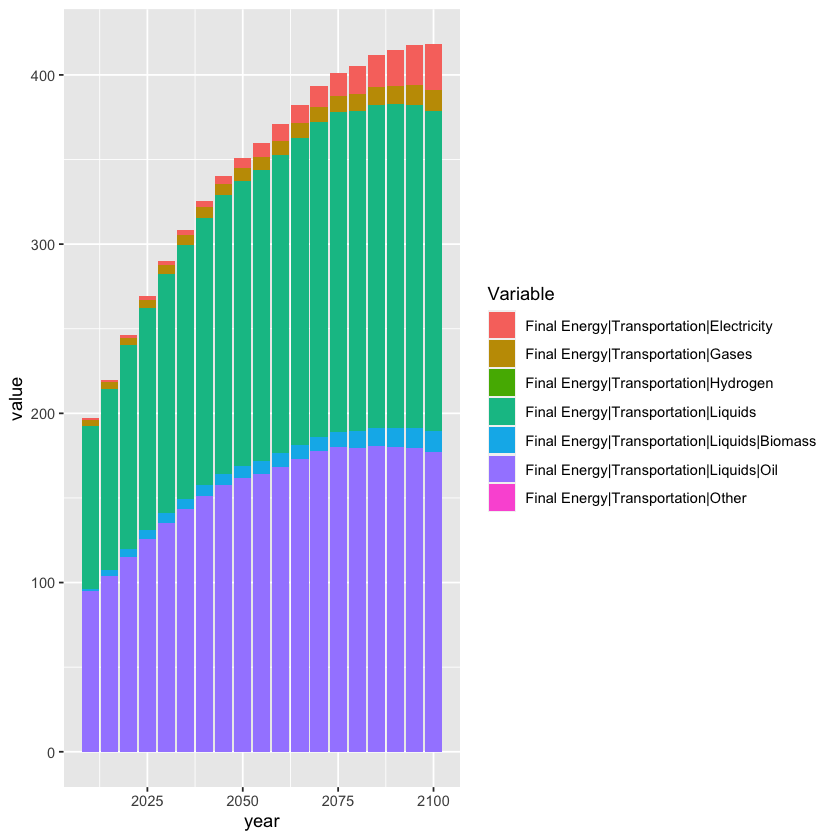

In [21]:
ggplot(input2[grep("Final Energy\\|Transportation\\|", input2$Variable),], aes(year, value, fill=Variable)) + geom_col()

# A common baseline

Let's get a common version of our final model from Lab 3, modified to use this new data.

In [ ]:
## Parameters
RR = 3.8 # Forcing at 2x CO2
C0 = 280 # Pre-industrial CO2
c = 0.098 # reaction rate of atmosphere
ECS = 3 # Equilibrium climate sensitivity
alpha = 1.0038 # Damage function scale
c.1960 = 3585.427 # GDP p.c. in 1960
c.2020 = 10542.301 # GDP p.c. in 2020
eta = 1.45 # Elasticity of marginal consumption

## Load the CO2 concentrations
co2 = read.csv("~/groups/ccecon/labs/lab3 - social cost of carbon/co2_ppm.csv")
## Select the SSP2-4.5 scenario for concentrations after 1960
co2.ssp245 = subset(co2, scenario == 'ssp245' & year > 1960)

## Set up the initial values: T_1960 = 0.2 C.
df = data.frame(year=1960, T=0.2, D=NA, cbar=NA, u=NA)
## Loop over all years from 1960 to 2300
for (tt in 1961:2300) {
  ## Retrieve the CO2 concentration in year tt
  C1 = co2.ssp245$value[co2.ssp245$year == tt]
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cbar = (c.2020 - c.1960) * (tt - 1960) / (2020 - 1960) + c.1960
  cc = cbar * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, T=T, D=D, cbar, u=uu))
}

Now replace the CO2 concentration data.

In [25]:
unique(input2$Variable[input2$Unit == 'ppm'])

[1] "Diagnostics|MAGICC6|Concentration|CO2"

In [26]:
co2 = subset(input2, Variable == 'Diagnostics|MAGICC6|Concentration|CO2')

In [27]:
head(co2)

,Model,Scenario,Region,Variable,Unit,variable,value,year
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1301,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2005,379.8500,2005
1552,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2006,381.8050,2006
1803,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2007,383.7500,2007
2054,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2008,385.8500,2008
2305,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2009,388.1892,2009
2556,AIM/CGE V2.2,EN_NPi2100,World,Diagnostics|MAGICC6|Concentration|CO2,ppm,X2010,390.5047,2010


* What does it look like?

In [29]:
## Parameters
RR = 3.8 # Forcing at 2x CO2
C0 = 280 # Pre-industrial CO2
c = 0.098 # reaction rate of atmosphere
ECS = 3 # Equilibrium climate sensitivity
alpha = 1.0038 # Damage function scale
c.1960 = 3585.427 # GDP p.c. in 1960
c.2020 = 10542.301 # GDP p.c. in 2020
eta = 1.45 # Elasticity of marginal consumption

## Set up the initial values: T_2009 from dataset
T.2009 = temp$value[temp$year == 2009]

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
  ## Retrieve the CO2 concentration in year tt
  C1 = co2$value[co2$year == tt]
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cbar = (c.2020 - c.1960) * (tt - 1960) / (2020 - 1960) + c.1960
  cc = cbar * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, T=T, D=D, cbar, u=uu))
}

In [30]:
tail(df)

,year,T,D,cbar,u
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87,2095,3.914250,15.37958,19238.39,-0.02828445
88,2096,3.948258,15.64798,19354.34,-0.02824842
89,2097,3.982285,15.91886,19470.29,-0.02821341
90,2098,4.016306,16.19201,19586.24,-0.02817936
91,2099,4.050314,16.46738,19702.19,-0.02814626
92,2100,4.084326,16.74511,19818.13,-0.02811414


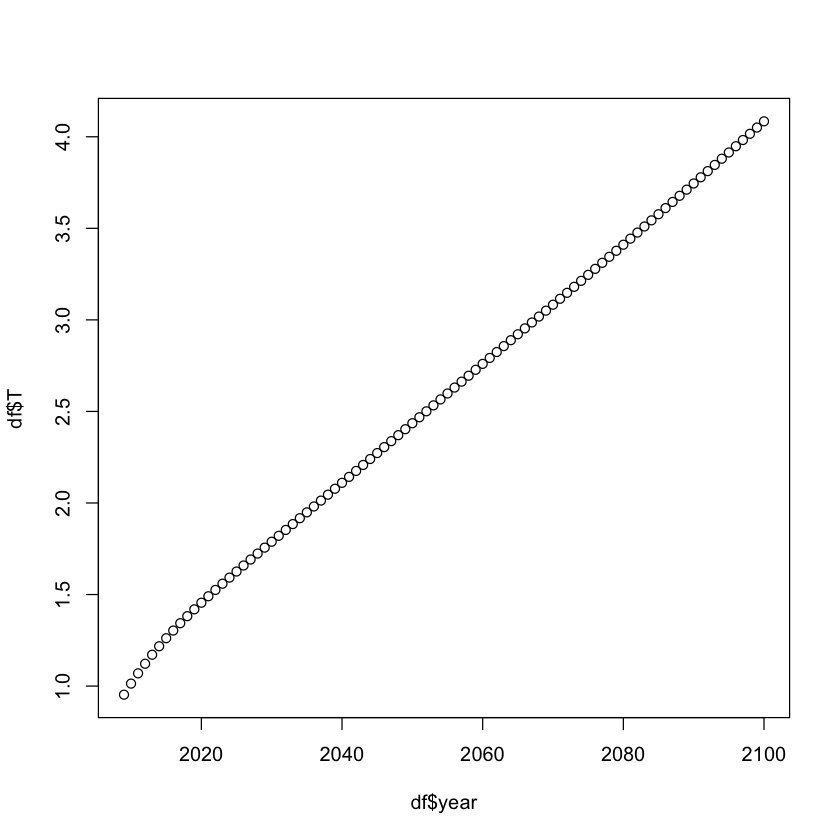

In [31]:
plot(df$year, df$T)

* Look at the results.

# Kaya identity emissions

We are going to use our simplified model of emissions, the Kaya identity.

$$Emissions = POP \times \frac{GDP}{POP} \times \frac{Energy}{GDP} \times \frac{Emissions}{Energy}$$

$$Emissions = POP \times \frac{GDP}{POP} \times \frac{Emissions}{GDP}$$

* What is the Kaya identity?

In [46]:
pop = subset(input2, Variable == 'Population')

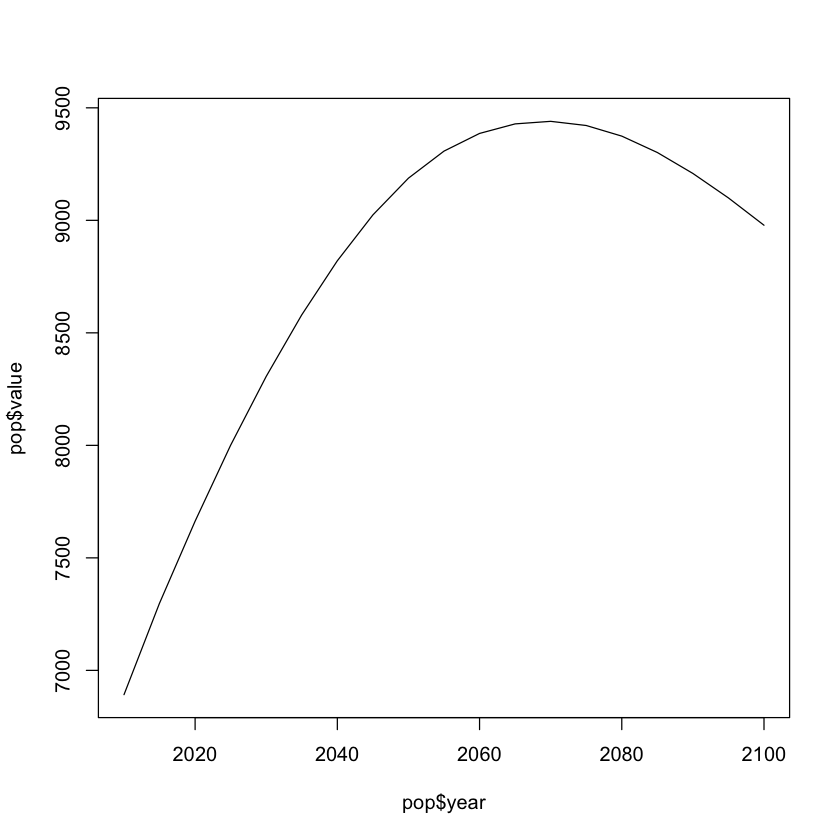

In [47]:
plot(pop$year, pop$value, type='l')

In [36]:
gdp = subset(input2, Variable == 'GDP|PPP')

In [37]:
gdp$gdppc = gdp$value / pop$value

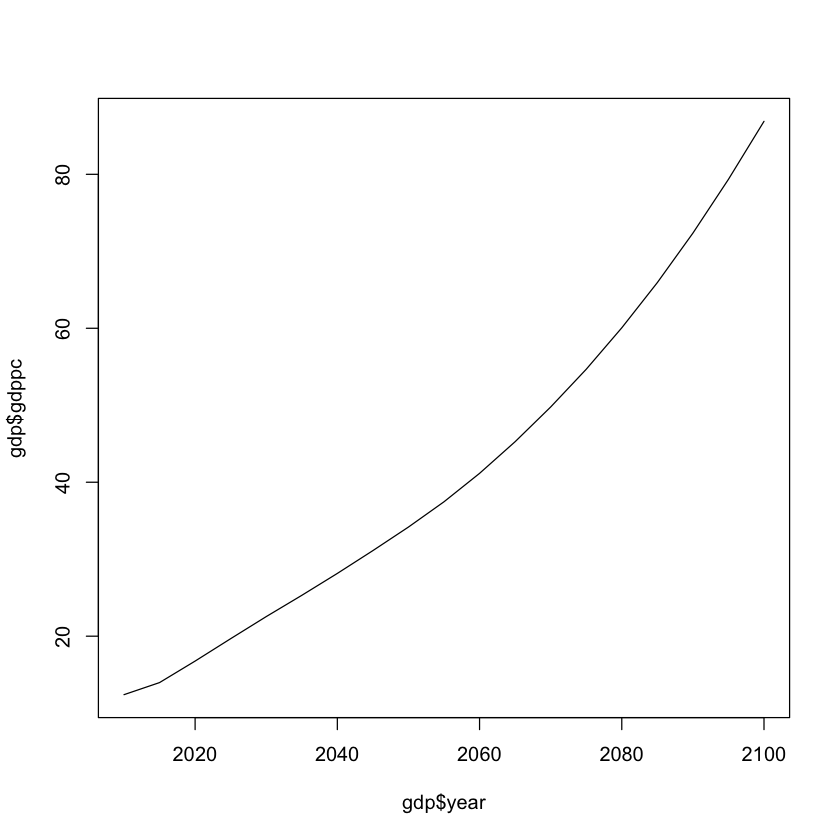

In [38]:
plot(gdp$year, gdp$gdppc, type='l')

In [39]:
energy = subset(input2, Variable == 'Primary Energy')

In [40]:
energy$intensity = energy$value / gdp$value

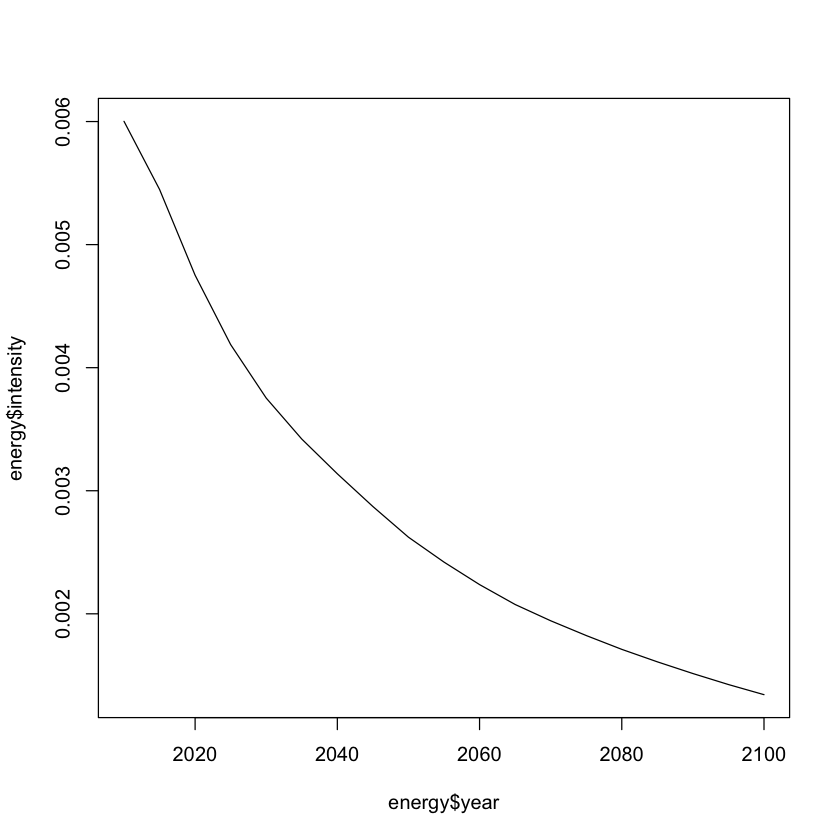

In [41]:
plot(energy$year, energy$intensity, type='l')

In [42]:
emits = subset(input2, Variable == 'Emissions|Kyoto Gases')

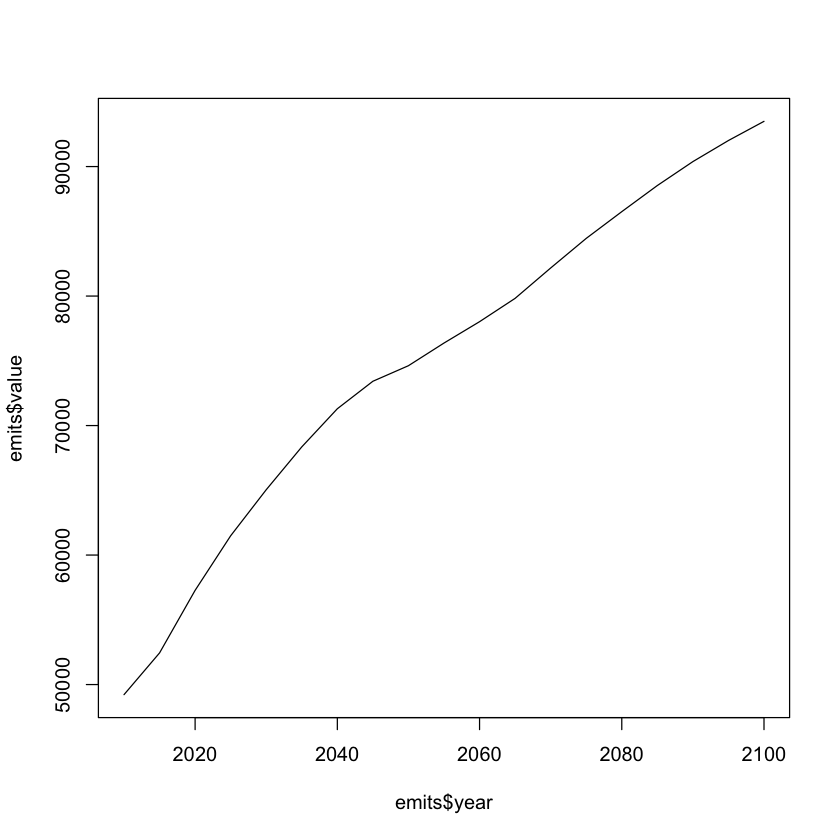

In [43]:
plot(emits$year, emits$value, type='l')

In [48]:
emits$intensity = emits$value / energy$value

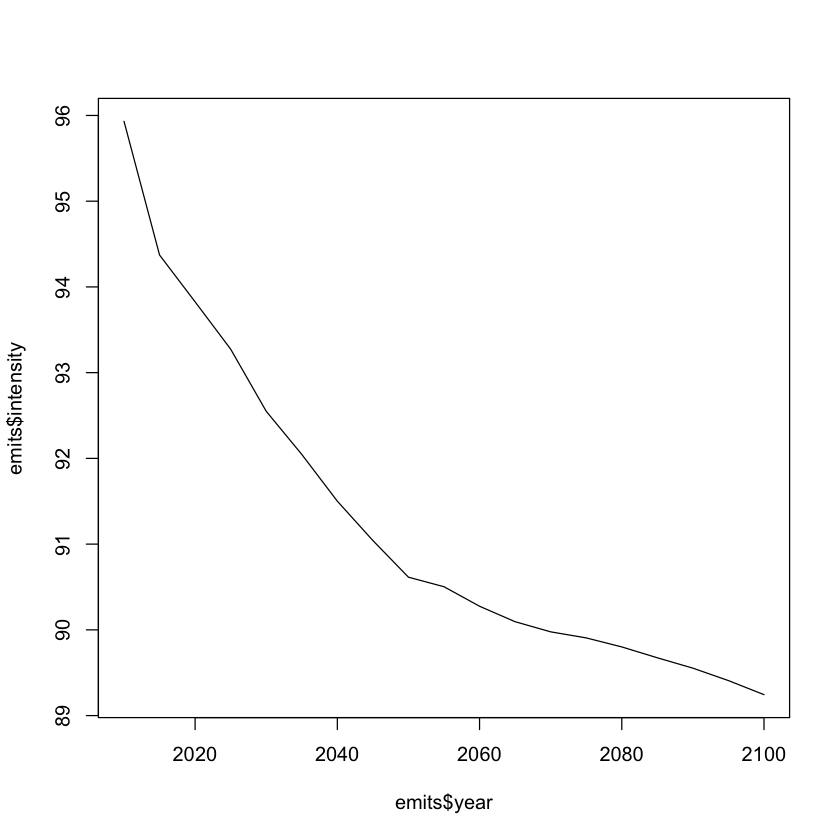

In [49]:
plot(emits$year, emits$intensity, type='l')

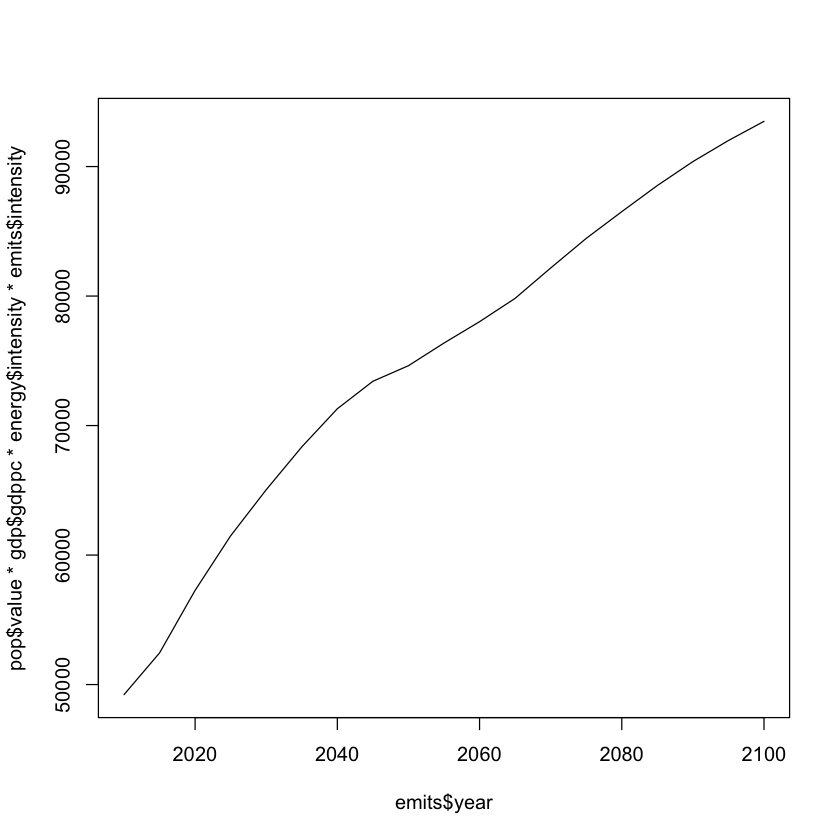

In [50]:
plot(emits$year, pop$value * gdp$gdppc * energy$intensity * emits$intensity, type='l')

In [51]:
emits$cigdp = emits$value / gdp$value

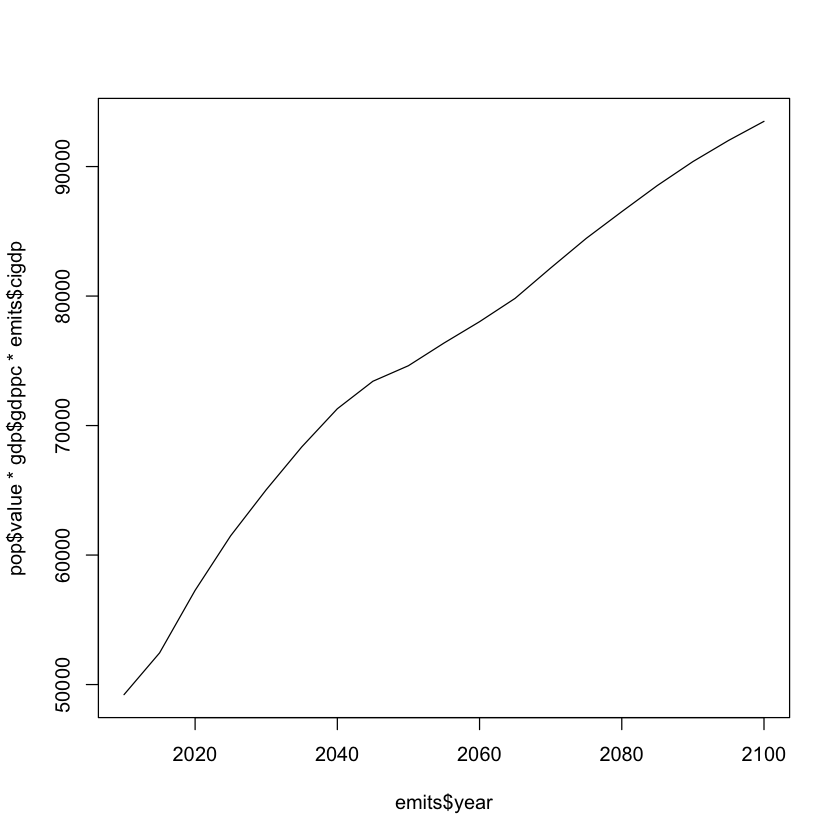

In [52]:
plot(emits$year, pop$value * gdp$gdppc * emits$cigdp, type='l')

In [53]:
future = data.frame(year=2010:2100, pop=approx(emits$year, pop$value, 2010:2100)$y,
                    gdppc=approx(gdp$year, gdp$gdppc, 2010:2100)$y,
                    cigdp=approx(emits$year, emits$cigdp, 2010:2100)$y)

In [55]:
head(pop)

,Model,Scenario,Region,Variable,Unit,variable,value,year
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>
2715,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2010,6892.060,2010
3970,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2015,7298.871,2015
5225,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2020,7663.041,2020
6480,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2025,8000.917,2025
7735,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2030,8306.489,2030
8990,AIM/CGE V2.2,EN_NPi2100,World,Population,Million,X2035,8580.166,2035


In [54]:
head(future)

,year,pop,gdppc,cigdp
,<int>,<dbl>,<dbl>,<dbl>
1,2010,6892.060,12.40366,0.5757548
2,2011,6973.422,12.71777,0.5634369
3,2012,7054.784,13.03188,0.5511190
4,2013,7136.146,13.34599,0.5388011
5,2014,7217.508,13.66011,0.5264832
6,2015,7298.871,13.97422,0.5141654


We can use a simple OLS model to find the conversion from emissions to ppm.

$$ppm_t = \alpha + \beta \sum_{s \le t} emit_t + \epsilon_t$$

In [56]:
future$pop * future$gdppc * future$cigdp

[1] 49219.41 49969.18 50668.29 51314.86 51907.00 52442.81 53617.63 54691.56
 [9] 55661.28 56523.43 57274.69 58304.87 59244.04 60089.58 60838.91 61489.41
[17] 62353.34 63142.65 63855.52 64490.12 65044.63 65820.42 66540.26 67202.97
[25] 67807.37 68352.29 69045.76 69687.95 70277.94 70814.85 71297.74 71828.41
[33] 72306.79 72732.14 73103.71 73420.77 73766.99 74060.85 74301.76 74489.16
[41] 74622.48 75060.90 75455.42 75805.69 76111.37 76372.09 76794.42 77170.72
[49] 77500.77 77784.34 78021.17 78472.93 78879.10 79239.55 79554.14 79822.77
[57] 80373.98 80884.10 81353.11 81780.96 82167.64 82706.45 83204.39 83661.51
[65] 84077.85 84453.46 84951.61 85406.95 85819.60 86189.69 86517.35 87006.15
[73] 87452.13 87855.49 88216.40 88535.07 88992.19 89405.28 89774.60 90100.41
[81] 90382.95 90798.32 91168.60 91494.07 91775.04 92011.81 92396.66 92736.81
[89] 93032.59 93284.34 93492.37

In [57]:
sum(future$pop * future$gdppc * future$cigdp)

[1] 6849129

In [58]:
cumsum(future$pop * future$gdppc * future$cigdp)

[1]   49219.41   99188.59  149856.89  201171.75  253078.75  305521.56
 [7]  359139.18  413830.74  469492.02  526015.45  583290.14  641595.01
[13]  700839.04  760928.63  821767.54  883256.95  945610.29 1008752.94
[19] 1072608.46 1137098.58 1202143.22 1267963.63 1334503.89 1401706.86
[25] 1469514.23 1537866.53 1606912.29 1676600.23 1746878.18 1817693.02
[31] 1888990.76 1960819.17 2033125.96 2105858.10 2178961.82 2252382.58
[37] 2326149.58 2400210.42 2474512.19 2549001.35 2623623.83 2698684.73
[43] 2774140.15 2849945.84 2926057.21 3002429.31 3079223.72 3156394.45
[49] 3233895.22 3311679.56 3389700.73 3468173.66 3547052.76 3626292.31
[55] 3705846.45 3785669.22 3866043.19 3946927.29 4028280.40 4110061.37
[61] 4192229.01 4274935.46 4358139.86 4441801.37 4525879.22 4610332.68
[67] 4695284.29 4780691.24 4866510.84 4952700.52 5039217.87 5126224.02
[73] 5213676.15 5301531.64 5389748.04 5478283.11 5567275.30 5656680.58
[79] 5746455.18 5836555.59 5926938.54 6017736.87 6108905.46 6200399.53
[85] 6292174.57 6384186.37 6476583.04 6569319.85 6662352.45 6755636.78
[91] 6849129.16

In [59]:
yy = co2$value[co2$year >= 2010 & co2$year <= 2100]
xx = cumsum(future$pop * future$gdppc * future$cigdp)

In [60]:
lm(yy ~ xx)


Call:
lm(formula = yy ~ xx)

Coefficients:
(Intercept)           xx  
  3.807e+02    5.382e-05  


In [61]:
summary(lm(yy ~ xx))


Call:
lm(formula = yy ~ xx)

Residuals:
   Min     1Q Median     3Q    Max 
-4.823 -3.724 -1.076  3.000 11.143 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.807e+02  8.297e-01   458.8   <2e-16 ***
xx          5.382e-05  2.225e-07   241.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.26 on 89 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9985 
F-statistic: 5.854e+04 on 1 and 89 DF,  p-value: < 2.2e-16


Test it with emissions:

In [66]:
emit2ppm = 5.382e-05

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
  ## Retrieve the CO2 concentration in year tt
  C1 = df$C1[nrow(df)] + ifelse(tt > 2022, 0, future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * emit2ppm)
  ## Calculate the radiative foring
  F = (RR / log(2)) * log(C1 / C0)
  ## Update the warming level, using the last row of df for the previous year
  T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
  ## Compute the damages
  D = alpha * T^2
  ## Compute social welfare
  cc = future$gdppc[tt-2009] * (1 - D / 100)
  uu = (cc^(1 - eta)) / (1 - eta)
  ## Add on the results for the new year to df
  df = rbind(df, data.frame(year=tt, C1=C1, T=T, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

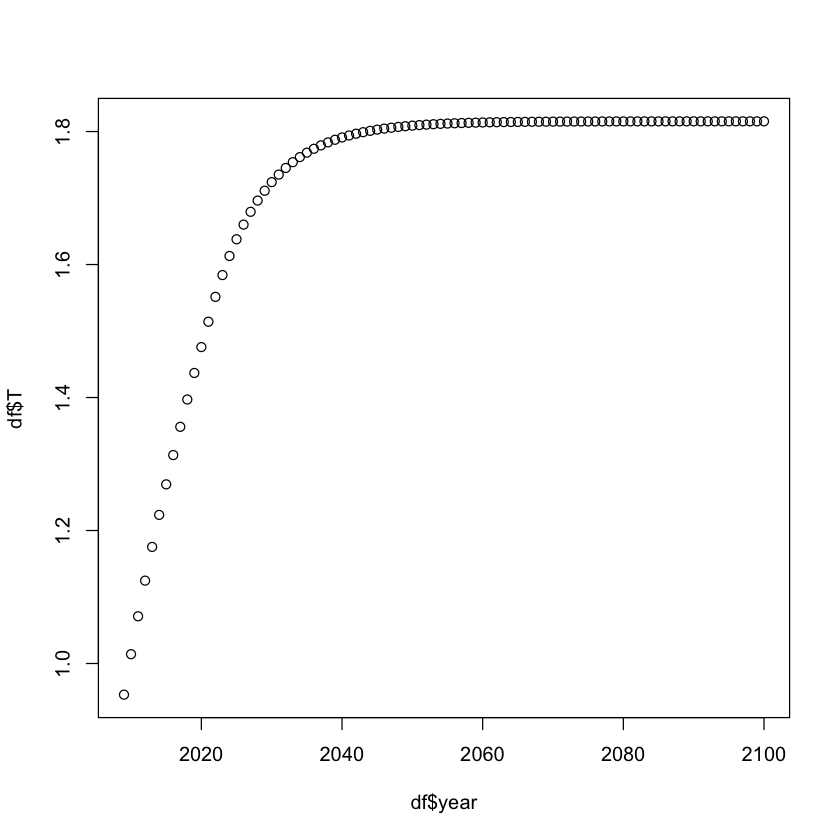

In [67]:
plot(df$year, df$T)

* What happens if we shut off emissions?

# Mitigation costs

We need an estimate of global mitigation costs. Let's use the McKinsey curve:
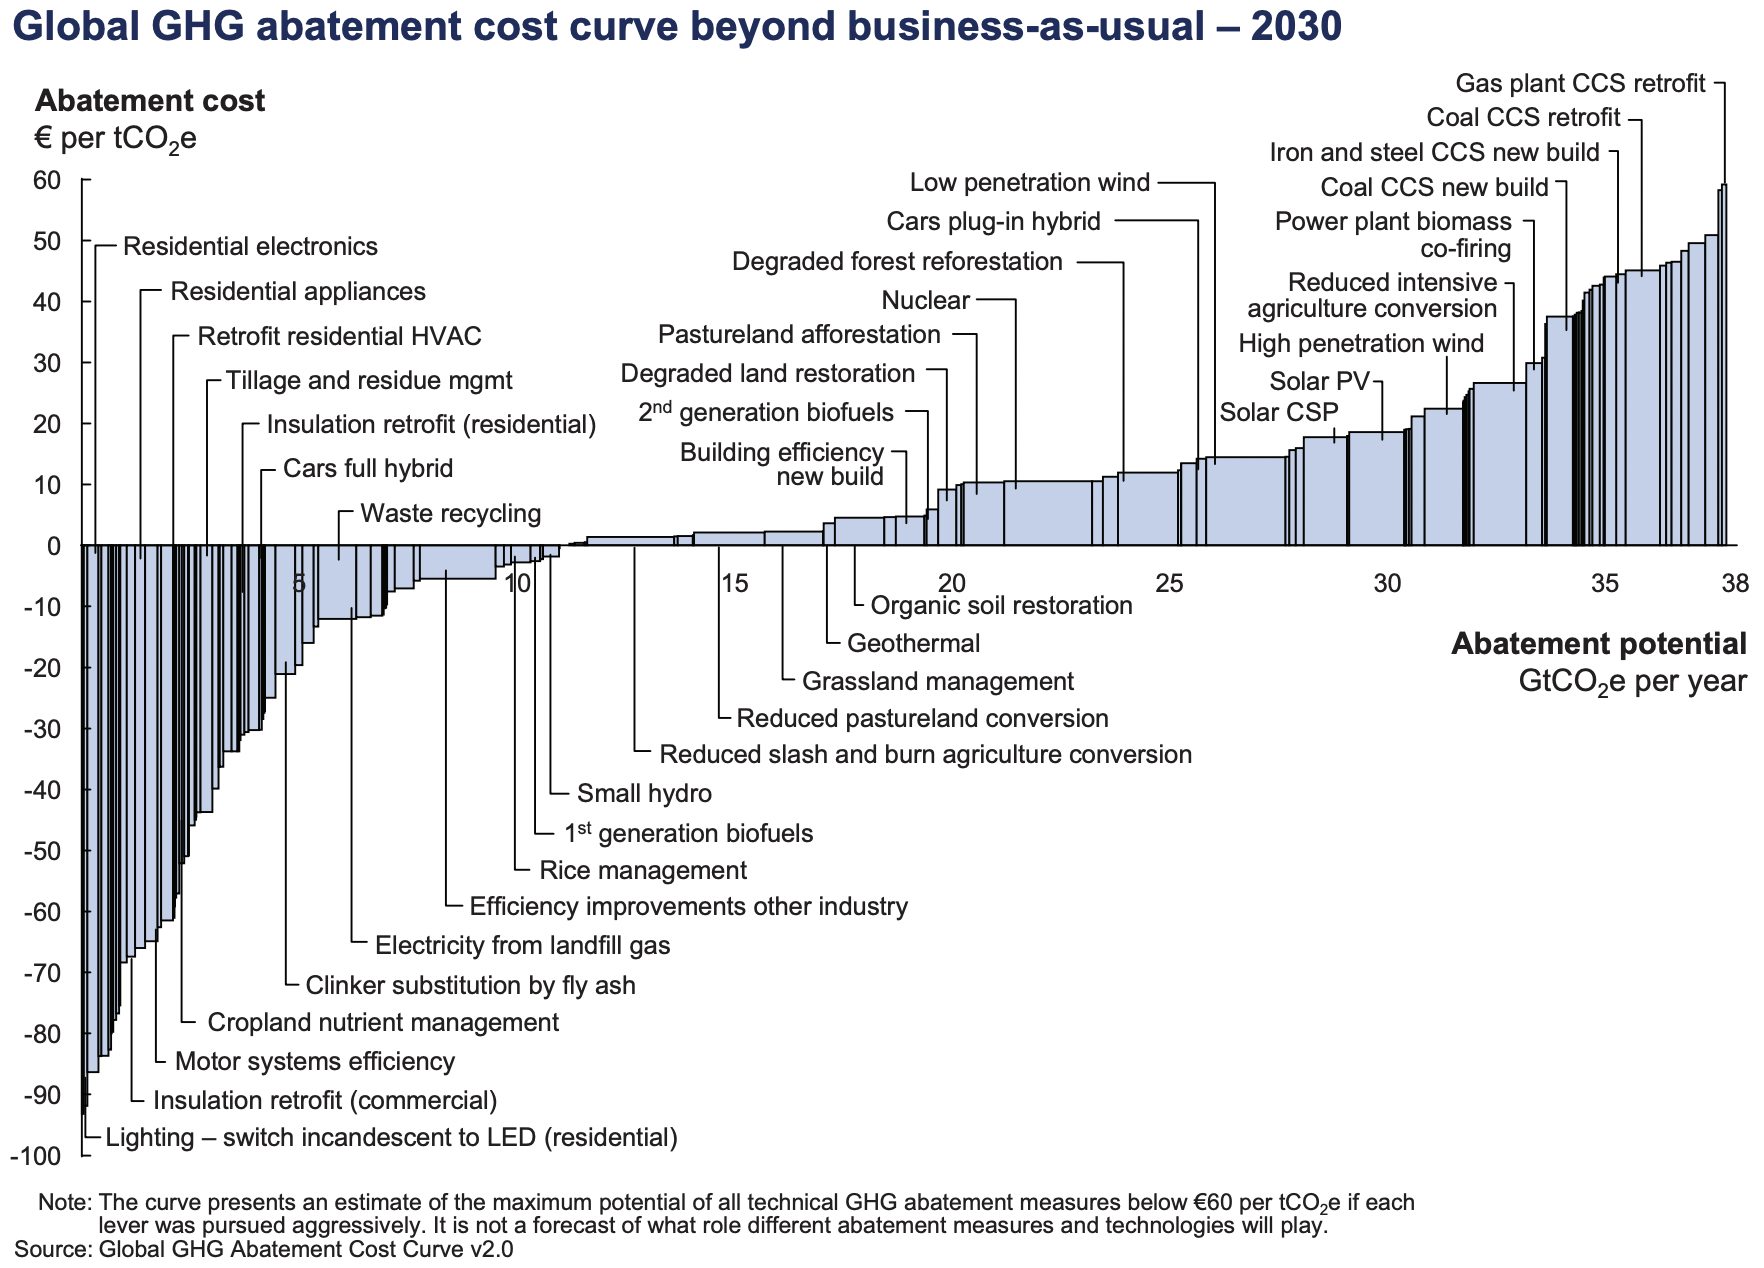

Let's break this up into multiple segments.

In [70]:
xx = c(0, 5, 30, 38)
yy = c(-90, -15, 20, 50)

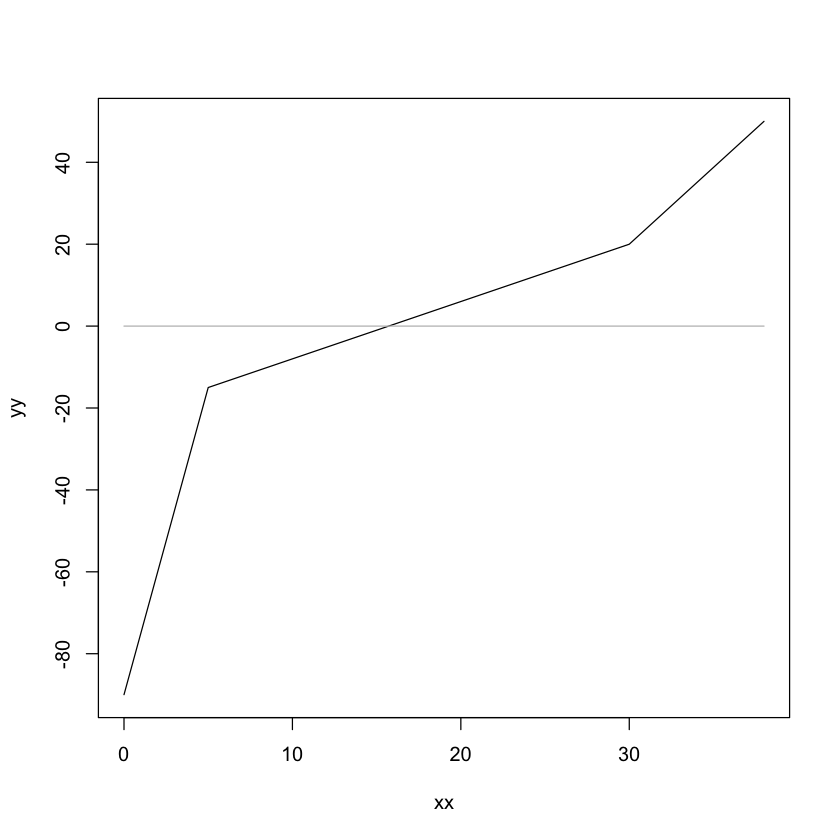

In [71]:
plot(xx, yy, type='l')
lines(c(0, 38), c(0, 0), col='grey')

## Some other considerations for mitigation costs

McKinsey curve is a theoretical ideal. It would be nice to account for:

1. Switching costs (to explain why people don't already apply no-regret gains)
2. Acellerated change costs (faster change means abandoning capital)
3. Lack of efficient ordering (working on changes across the MAC curve)

Define a reduction path as an exponential approach to 100% abatement.

In [82]:
rate = 20
tt = 2010:2100
abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)

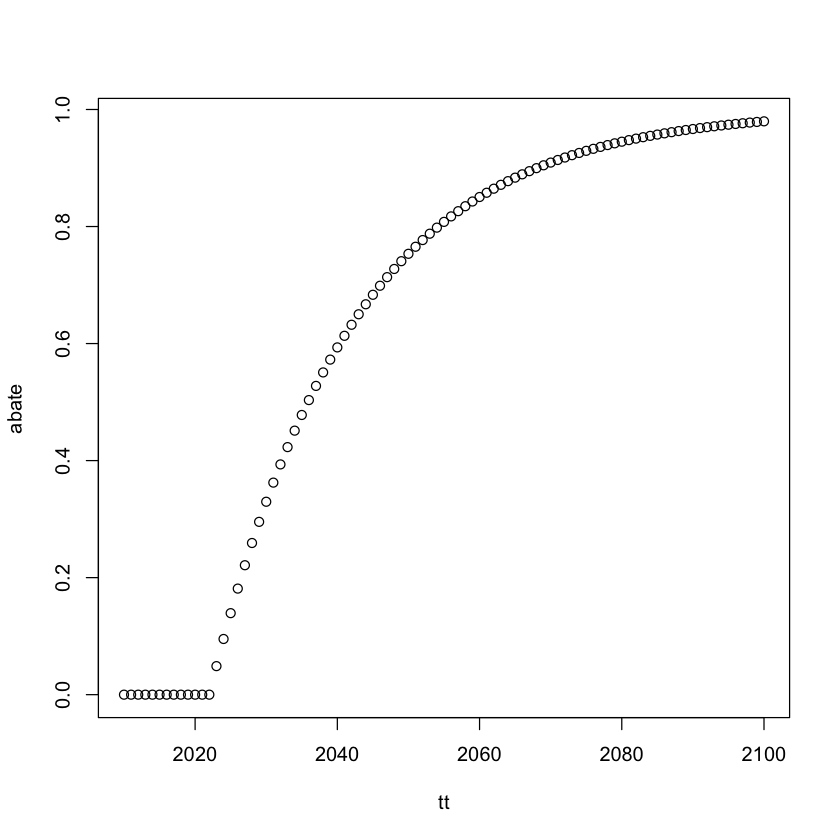

In [83]:
plot(tt, abate)

In [86]:
rate = 10

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
    # Abatement
    abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
    ## Retrieve the CO2 concentration in year tt
    C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
    ## Calculate the radiative foring
    F = (RR / log(2)) * log(C1 / C0)
    ## Update the warming level, using the last row of df for the previous year
    T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
    ## Compute the damages
    D = alpha * T^2
    ## Compute social welfare
    cc = future$gdppc[tt-2009] * (1 - D / 100)
    uu = (cc^(1 - eta)) / (1 - eta)
    ## Add on the results for the new year to df
    df = rbind(df, data.frame(year=tt, C1=C1, T=T, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

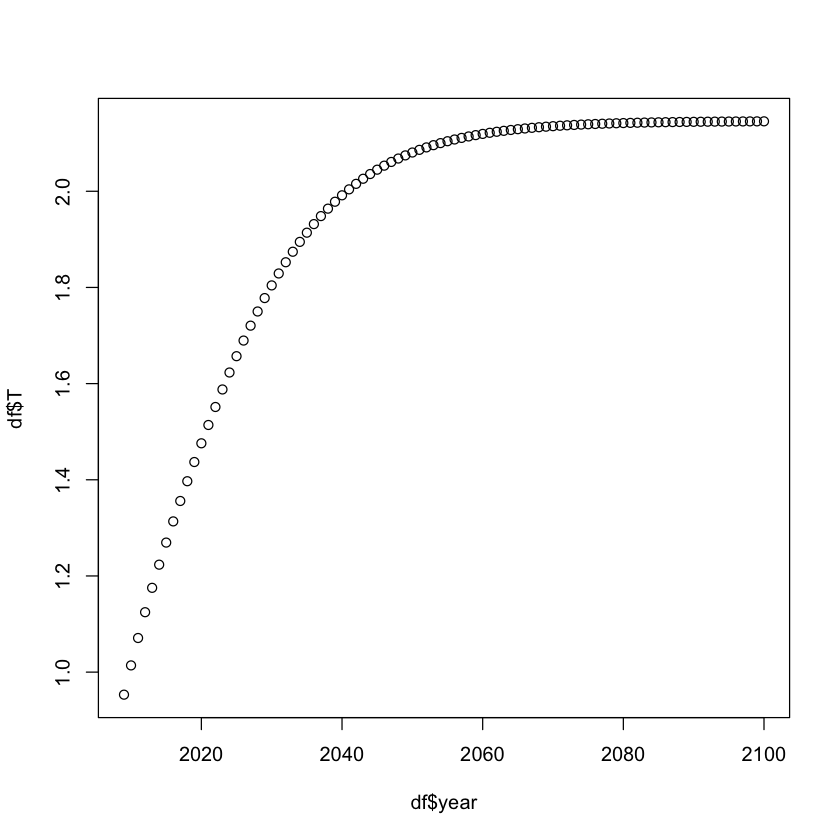

In [87]:
plot(df$year, df$T)

Now add on abatement costs.

In [88]:
tac = function(gt) {
    tot = 0
    if (gt == 0)
        return(tot)
    for (ii in which(xx < gt)[-1]) {
        slope = (yy[ii] - yy[ii-1]) / (xx[ii] - xx[ii-1])
        tot = tot + slope * (xx[ii] - xx[ii-1])^2 + yy[ii-1] * (xx[ii] - xx[ii-1])
    }
    last = tail(which(xx < gt), 1)
    slope = (yy[last+1] - yy[last]) / (xx[last+1] - xx[last])
    tot = tot + slope * (gt - xx[last])^2 + yy[last] * (gt - xx[last])
    tot * 1e9 * 1.07
}

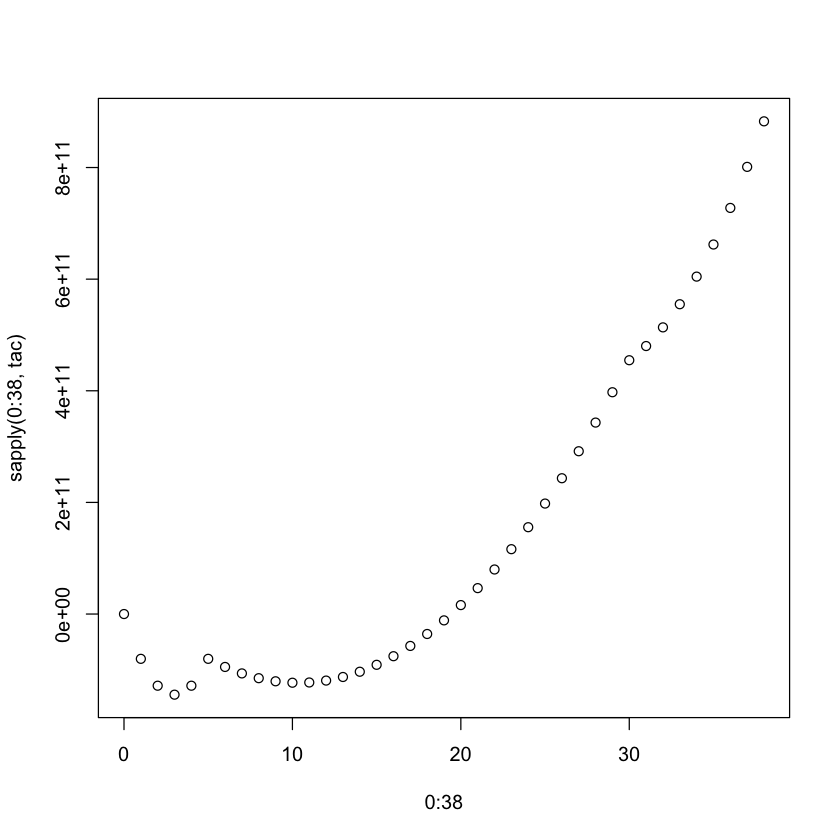

In [89]:
plot(0:38, sapply(0:38, tac))

* How do we plot it?

## Acellerated change

Additional costs of mitigation equal to
$$GDP \left(\frac{dr}{dt}\right)^2$$

In [98]:
rate = 10

## Loop over all years from 2010 to 2100
df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                T=T.2009, abate=NA, cost=NA, D=NA, cbar=NA, u=NA)
for (tt in 2010:2100) {
    # Abatement
    abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
    ## Cost of abatement (in % GDP)
    cost = 100 * (tac(abate * 38) / 84.71e12 + (abate - df$abate[nrow(df)])^2)
    ## Retrieve the CO2 concentration in year tt
    C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
    ## Calculate the radiative foring
    F = (RR / log(2)) * log(C1 / C0)
    ## Update the warming level, using the last row of df for the previous year
    T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
    ## Compute the damages
    D = alpha * T^2
    ## Compute social welfare
    cc = future$gdppc[tt-2009] * (1 - D / 100 - cost / 100)
    uu = (cc^(1 - eta)) / (1 - eta)
    ## Add on the results for the new year to df
    df = rbind(df, data.frame(year=tt, C1=C1, T=T, abate=abate, cost=cost, D=D, cbar=future$gdppc[tt-2009], u=uu))
}

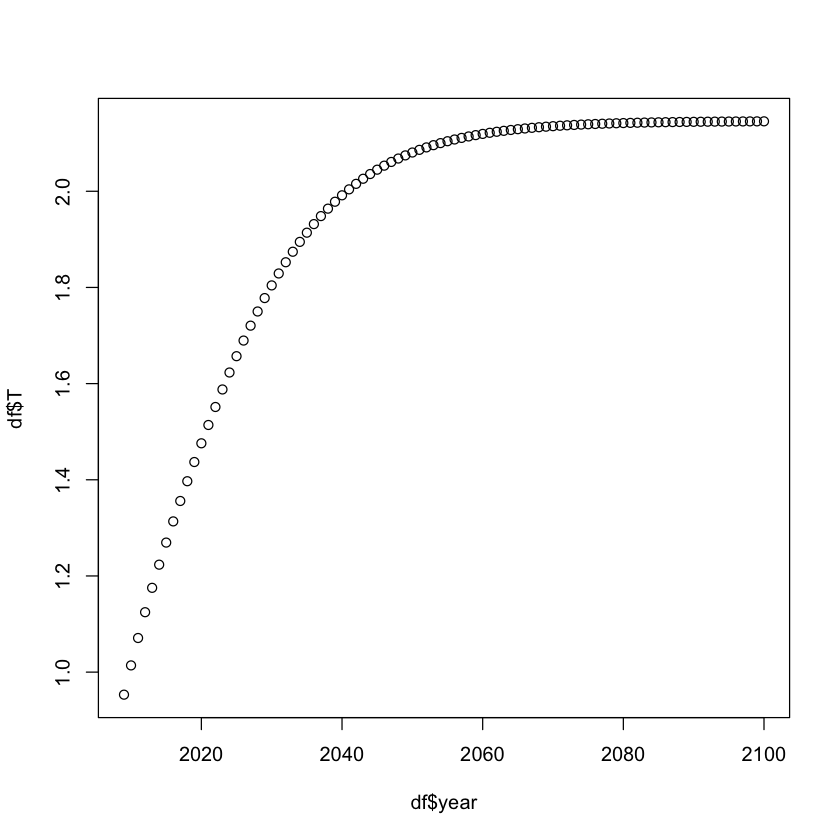

In [99]:
plot(df$year, df$T)

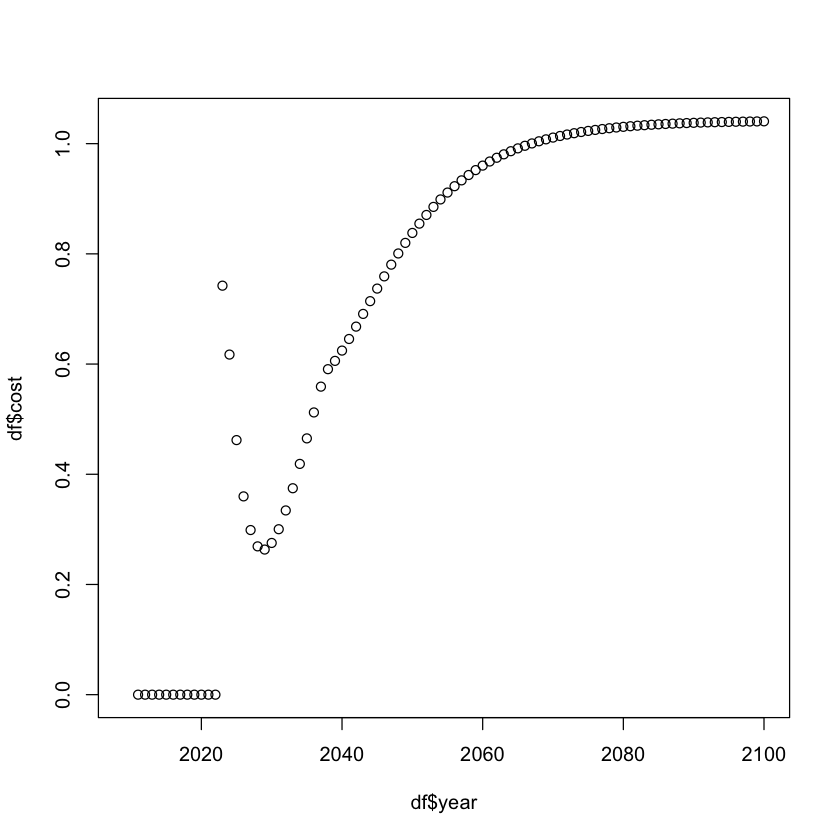

In [100]:
plot(df$year, df$cost)

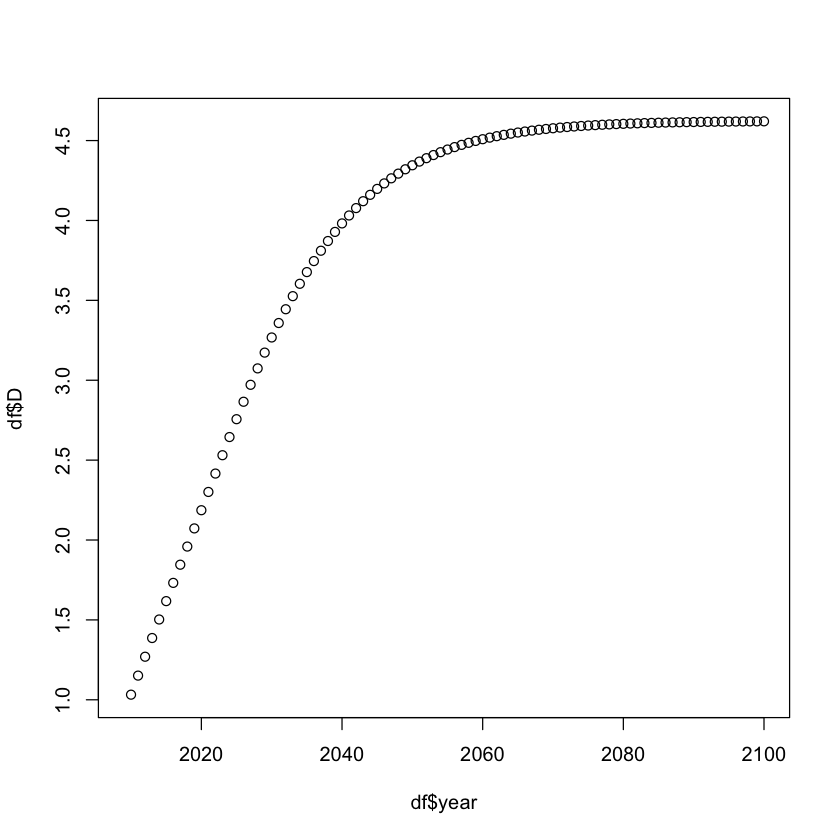

In [101]:
plot(df$year, df$D)

Wrap it in a function so we can do optimization:

In [102]:
simulate = function(rate) {
    ## Loop over all years from 2010 to 2100
    df = data.frame(year=2009, C1=co2$value[co2$year == 2009],
                    T=T.2009, abate=NA, cost=NA, D=NA, cbar=NA, u=NA)
    for (tt in 2010:2100) {
        # Abatement
        abate = ifelse(tt > 2022, 1 - exp(-(tt - 2022) / rate), 0)
        ## Cost of abatement (in % GDP)
        cost = 100 * (tac(abate * 38) / 84.71e12 + (abate - df$abate[nrow(df)])^2)
        ## Retrieve the CO2 concentration in year tt
        C1 = df$C1[nrow(df)] + future$pop[tt-2009] * future$gdppc[tt-2009] * future$cigdp[tt-2009] * (1 - abate) * emit2ppm
        ## Calculate the radiative foring
        F = (RR / log(2)) * log(C1 / C0)
        ## Update the warming level, using the last row of df for the previous year
        T = df$T[nrow(df)] + c * (F - (RR / ECS) * df$T[nrow(df)])
        ## Compute the damages
        D = alpha * T^2
        ## Compute social welfare
        cc = future$gdppc[tt-2009] * (1 - D / 100 - cost / 100)
        uu = (cc^(1 - eta)) / (1 - eta)
        ## Add on the results for the new year to df
        df = rbind(df, data.frame(year=tt, C1=C1, T=T, abate=abate, cost=cost, D=D, cbar=future$gdppc[tt-2009], u=uu))
    }
    
    df
}

In [103]:
df = simulate(10)

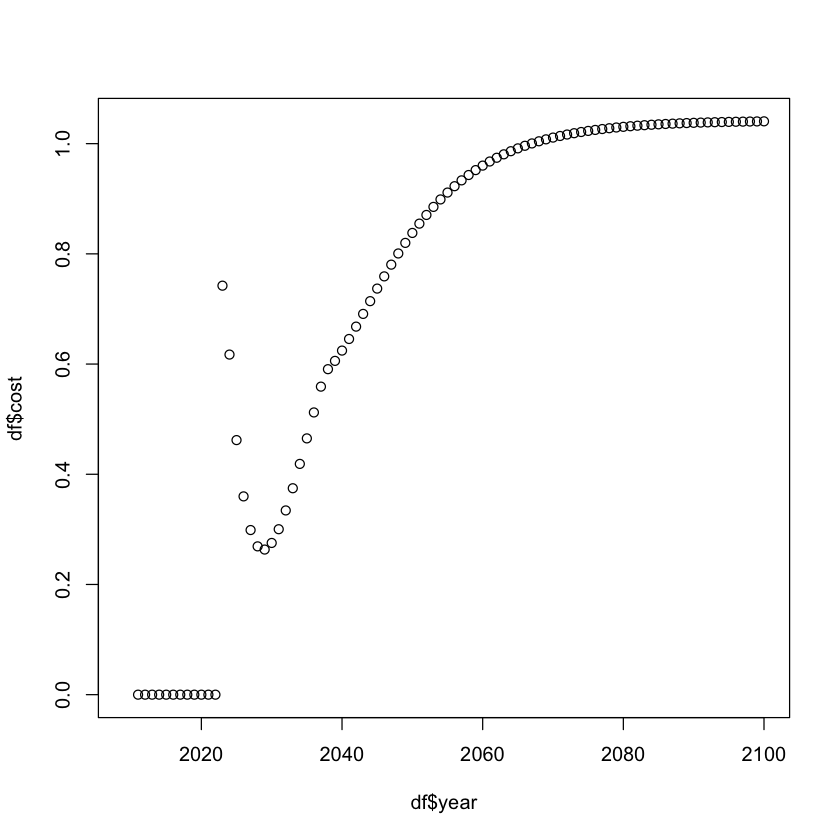

In [104]:
plot(df$year, df$cost)

Let's compare a couple simulations

In [105]:
df1 = simulate(10)
df2 = simulate(1e9)

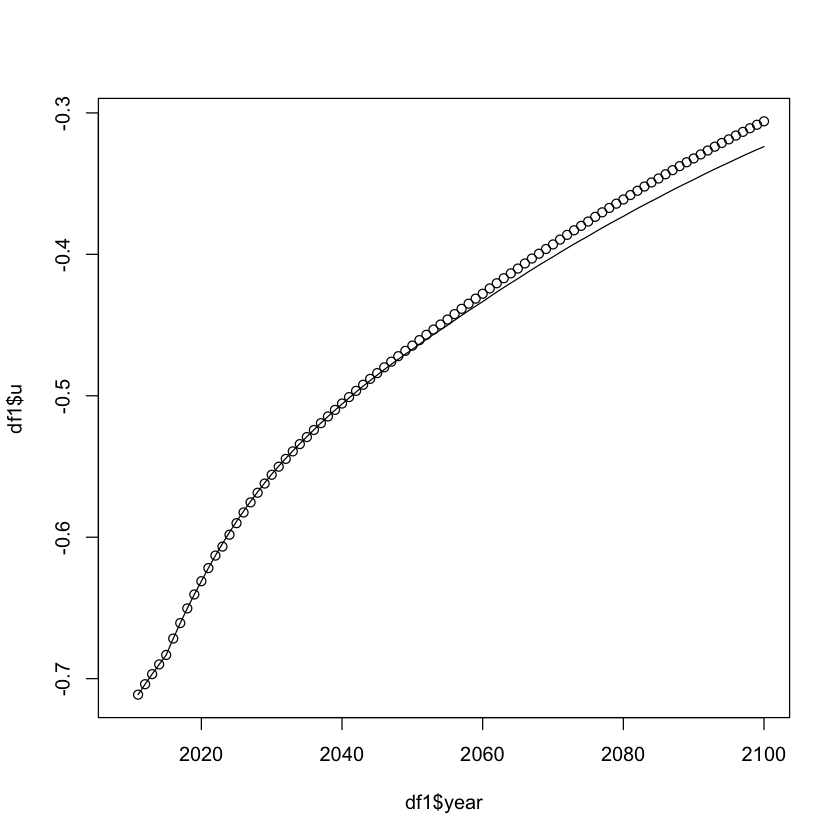

In [106]:
plot(df1$year, df1$u)
lines(df2$year, df2$u)

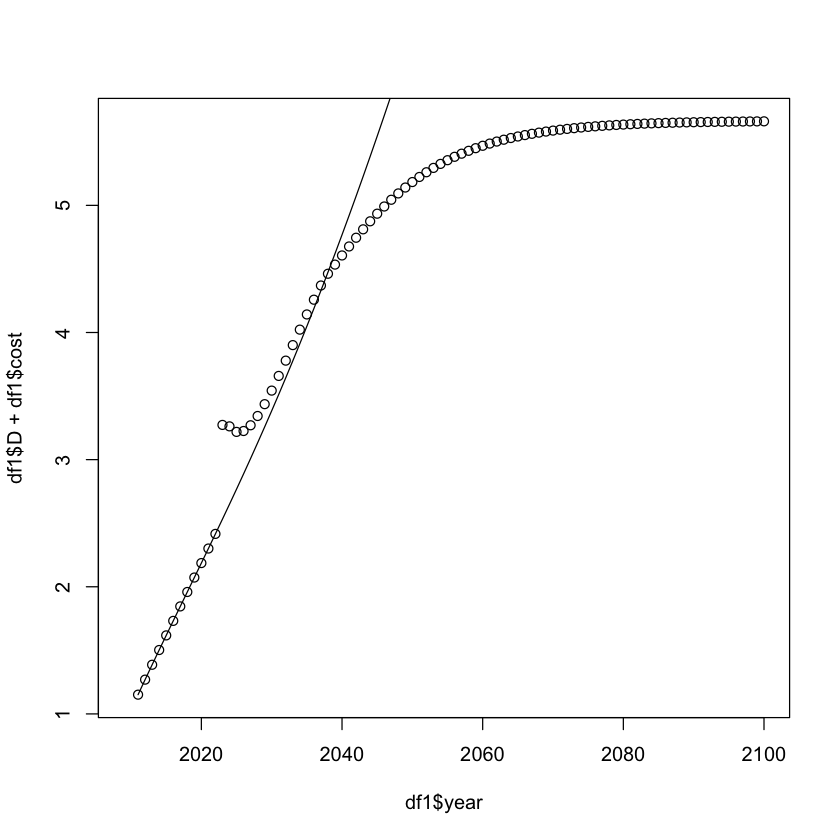

In [107]:
plot(df1$year, df1$D + df1$cost)
lines(df2$year, df2$D + df2$cost)

In [108]:
rho = 1.5 / 100
year0 = 2020

npv = function(rate) {
    df = simulate(rate)
    
    sum(df$u[df$year >= 2020] * (1 + rho)^(-(df$year[df$year >= 2020] - year0)))
}

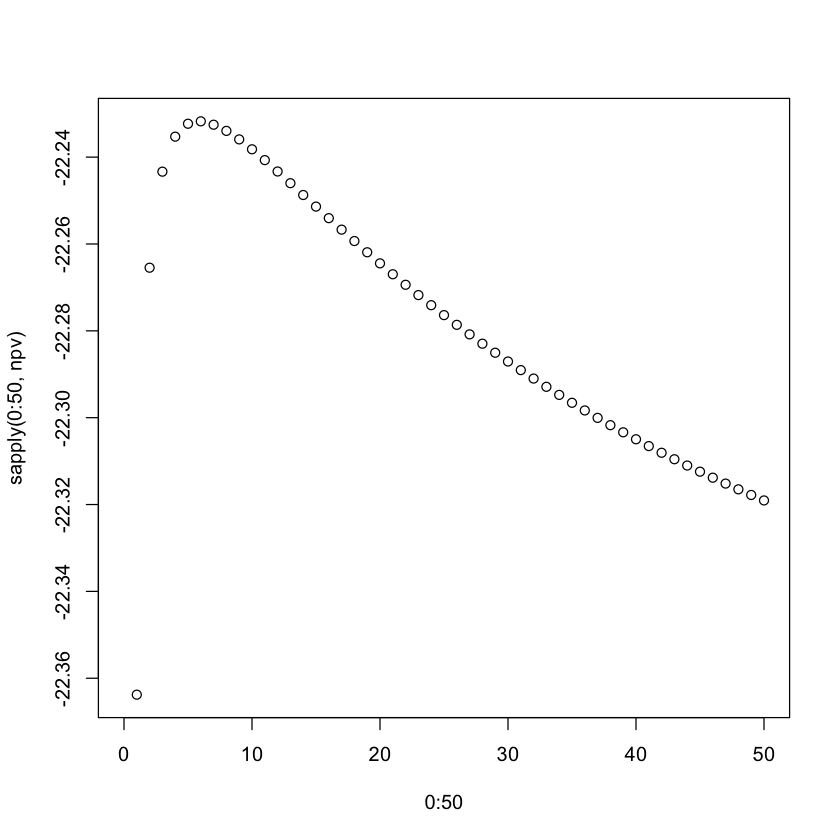

In [109]:
plot(0:50, sapply(0:50, npv))

In [110]:
optimize(npv, c(0, 50), maximum=TRUE)

$maximum
[1] 5.878134

$objective
[1] -22.23174

* Now simulate it!

In [115]:
simulate(5.87813368309425)

year,C1,T,abate,cost,D,cbar,u
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009,388.1892,0.9531263,NA,NA,NA,NA,NA
2010,390.8382,1.0139898,0.0000000,NA,1.032082,12.40366,NA
2011,393.5275,1.0709823,0.0000000,0.0000000,1.151362,12.71777,-0.7113212
2012,396.2545,1.1246103,0.0000000,0.0000000,1.269554,13.03188,-0.7039329
2013,399.0163,1.1753127,0.0000000,0.0000000,1.386609,13.34599,-0.6968005
2014,401.8099,1.2234698,0.0000000,0.0000000,1.502566,13.66011,-0.6899092
2015,404.6324,1.2694096,0.0000000,0.0000000,1.617524,13.97422,-0.6832461
2016,407.5181,1.3134648,0.0000000,0.0000000,1.731745,14.53274,-0.6716533
2017,410.4616,1.3559179,0.0000000,0.0000000,1.845500,15.09127,-0.6606955


In [111]:
df = simulate(5.87813368309425)

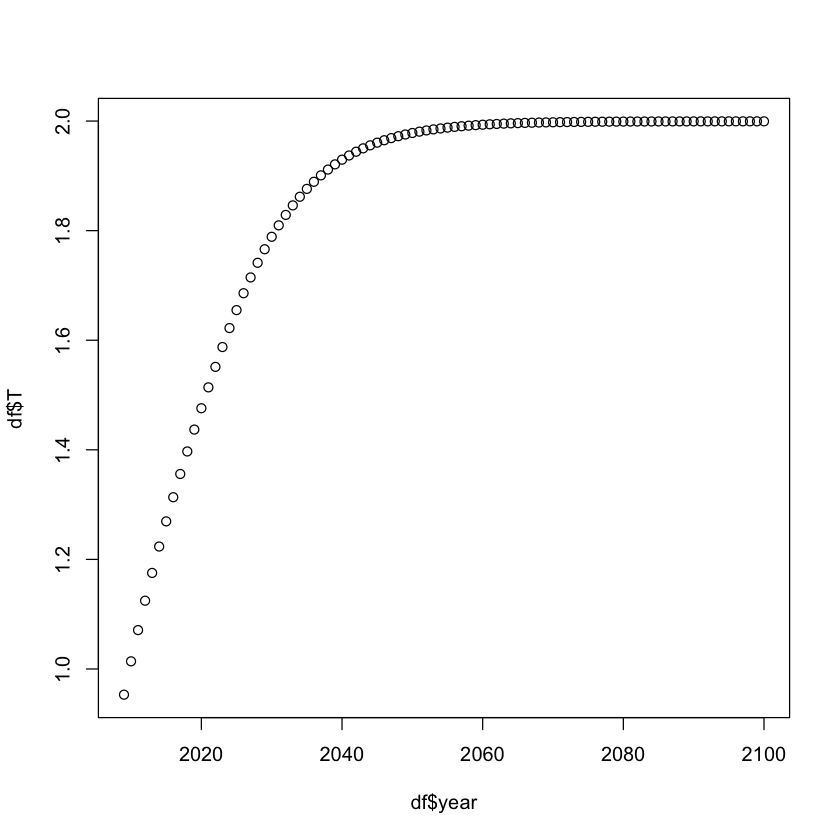

In [112]:
plot(df$year, df$T)

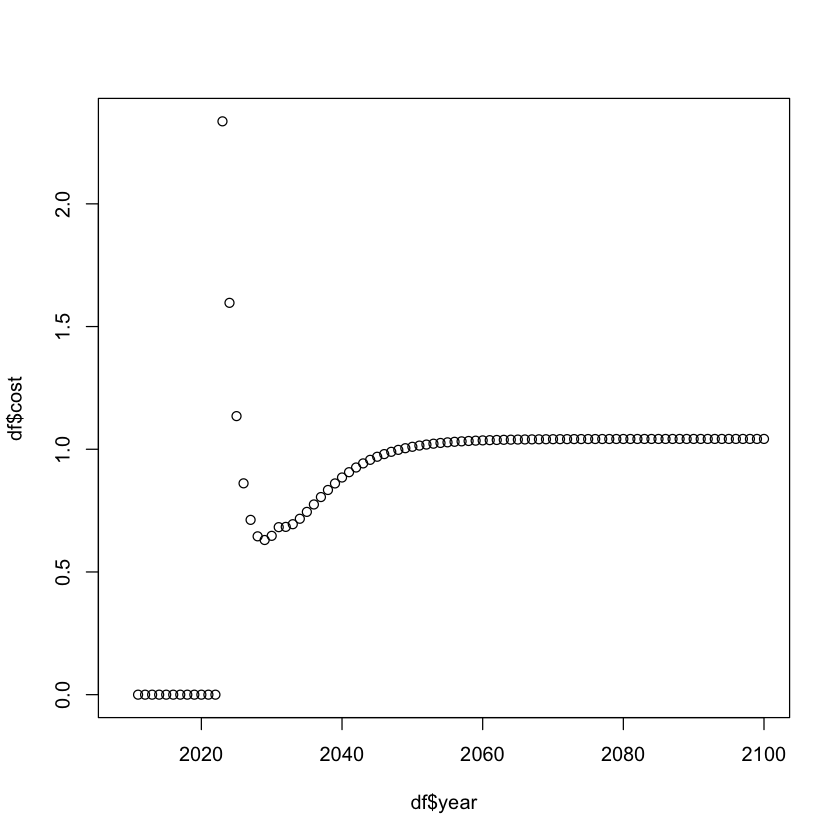

In [113]:
plot(df$year, df$cost)

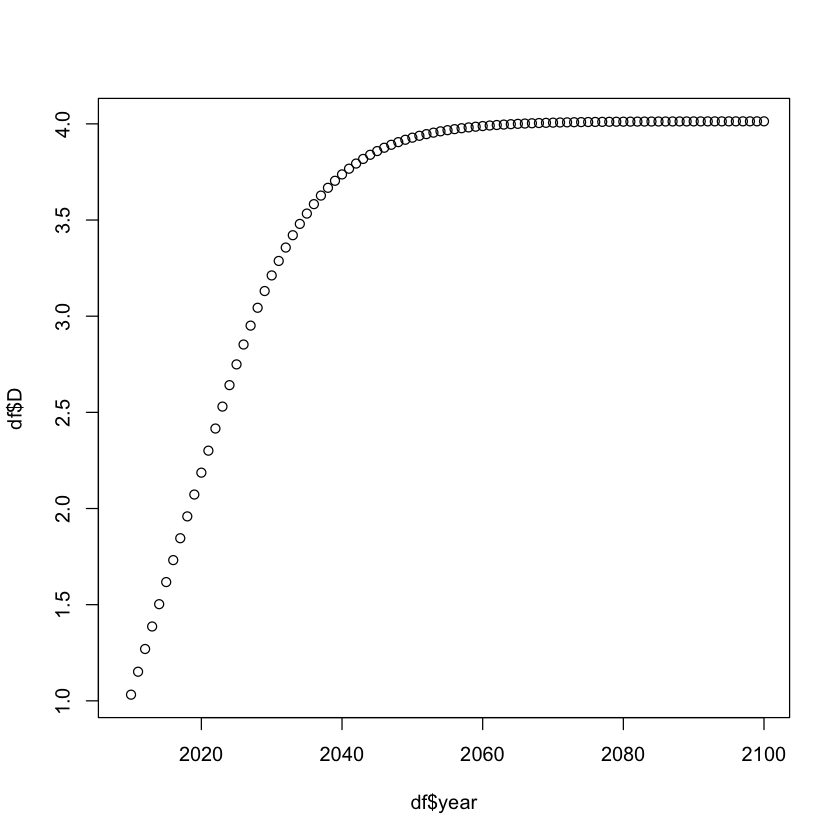

In [114]:
plot(df$year, df$D)